# Advantage Actor Critic (A2C)

-----------
### 0. Background: From Only Actor/Critic to Actor-Critic

In [REINFORCE](../../policy-based/policy-gradient-methods/improved-reinforce/improved_reinforce.ipynb) method, we have

$$
\nabla_\theta U(\theta) \approx \hat{g} = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=0}^T \nabla_{\theta} \log \pi_{\theta}(a_t | s_t) \cdot R_t^{\text{future}} \right]
$$

and now we consider discount factor

$$
\nabla_\theta U(\theta) \approx \hat{g} = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=0}^T \nabla_{\theta} \log \pi_{\theta}(a_t | s_t) \cdot \gamma^{t} R_t^{\text{future}} \right]
$$

and convert into below form, we make $G_t = \gamma^{t} R_t^{\text{future}}$
$$
\nabla_\theta U(\theta) \approx \hat{g} = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=0}^T \nabla_{\theta} \log \pi_{\theta}(a_t | s_t) \cdot G_t \right]
$$

in REINFORCE like method, we use actual observed trajectory to compute $G_t$, however, we need to collect whole trajectory for  policy gradient $\hat{g}$.

$$
G_t = r_t + \gamma G_{t+1}
$$

in Actor-Critic method, like [SARSA](../../../model-free-learning/discrete-state-problems/temporal-difference-methods/temporal_difference_blackjack.ipynb) we take a action $a_{t+1}$ at $s_{t+1}$ but not to interact with environment and compute $G_t = r_t + \gamma Q(s_{t+1}, a_{t+1})$, here we use **Value Network** to approximate $G_{t+1}$, so we have

$$
G_t = r_t + \gamma V(s_{t+1}; \theta)
$$


$$
\nabla_\theta U(\theta) \approx \hat{g} = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=0}^T \nabla_{\theta} \log \pi_{\theta}(a_t | s_t) \cdot G_t \right]
$$

-----------

### 1. Import the Necessary Packages

In this notebook, we will implement A2C and train a policy to play [atari-pong](https://ale.farama.org/environments/pong/), using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy.


In [1]:
import random
import numpy as np
from enum import Enum
import ale_py
import gymnasium as gym
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from parallel_env import ParallelEnv
from plot_utils import display_frame, save_animation, plot_scores


%matplotlib inline
gym.register_envs(ale_py)

device = torch.device("cuda:0" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print("using device: ",device)

using device:  mps


### 2. Explore Environment

<div style="text-align: center;">
        <img src="./images/pong.gif" alt="Mountain Car Environment" width="10%">
</div>

#### Continuous State Space
- **Observation Type**: `"rgb"`
- **Observation Space**: `Box(0, 255, (210, 160, 3), np.uint8)`
    - Observations are RGB images with dimensions 210x160 and 3 color channels. The pixel values range from 0 to 255.

#### Discrete Action Space
- **Type**: `Discrete(6)`
- **Actions**:
    - `0`: `NOOP` (No operation)
    - `1`: `FIRE`
    - `2`: `RIGHT`
    - `3`: `LEFT`
    - `4`: `RIGHTFIRE`
    - `5`: `LEFTFIRE`

> To simplify training, we will only use the following two actions:
> - `4`: `RIGHTFIRE`
> - `5`: `LEFTFIRE`

The `FIRE` part ensures the game starts again after losing a life.

#### Other Settings
1. **Frameskip**
        - **Value**: `4`
        - **Explanation**: The environment executes the same action for 4 consecutive frames before observing the next state. This deterministic frameskip makes the environment faster to train compared to the vanilla `Pong-v4`, which uses a stochastic frameskip of `(2, 5)`.

2. **Repeat Action Probability**
        - **Value**: `0.0`
        - **Explanation**: This setting ensures no randomness in action repetition. The same action will always have the same effect, making the environment fully deterministic and predictable.

By using deterministic frameskip and disabling action stickiness, `PongDeterministic-v4` is more efficient for training reinforcement learning models.


In [2]:
env = gym.make('PongDeterministic-v4')
# Explore state (observation) space
print("State space:\n", env.observation_space)

# Explore action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("Shape of State space 2 samples:")
print([env.observation_space.sample().shape for _ in range(2)])

# Generate some samples from the action space
print("Action space 2 samples:")
print(np.array([env.action_space.sample() for i in range(2)]))
env.close()

State space:
 Box(0, 255, (210, 160, 3), uint8)
Action space:
 Discrete(6)
--------------------------------------------------
Shape of State space 2 samples:
[(210, 160, 3), (210, 160, 3)]
Action space 2 samples:
[5 0]


A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


In [3]:
class Action(Enum):
    NOOP = 0         # No operation
    FIRE = 1         # Fire
    RIGHT = 2        # Move right
    LEFT = 3         # Move left
    RIGHTFIRE = 4    # Move right and fire
    LEFTFIRE = 5     # Move left and fire

### 3. Preprocessing

To speed up training, we can simplify the input by cropping the images and use every other pixel

<div style="text-align: center;">
    <img src="./images/preprocess.png" alt="Mountain Car Environment" width="50%">
</div>


In [4]:
def preprocess(image, bkg_color=np.array([144, 72, 17])):
    """
    Preprocess a single game frame by cropping, downsampling, and normalizing.

    Args:
        image (np.ndarray): The input image (game frame) as a NumPy array.
        bkg_color (np.ndarray): The RGB background color to subtract.

    Returns:
        np.ndarray: The processed image, normalized to [0, 1].
    """
    # Crop the image to remove irrelevant parts (e.g., score and borders)
    cropped_image = image[34:-16, :]
    # Downsample the image by taking every second pixel (both rows and columns)
    downsampled_image = cropped_image[::2, ::2]
    # Subtract the background color
    adjusted_image = downsampled_image - bkg_color
    # Convert to grayscale by taking the mean across the color channels
    grayscale_image = np.mean(adjusted_image, axis=-1)
    # Normalize pixel values to the range [0, 1]
    normalized_image = grayscale_image / 255.0

    return normalized_image


def preprocess_batch(images, bkg_color=np.array([144, 72, 17])):
    """
    Convert outputs of ParallelEnv to inputs for tensor processing.

    Args:
        images (list or np.ndarray): Batch of input images (game frames).
        bkg_color (np.ndarray): The RGB background color to subtract.
        device (str): The device to which the tensor will be moved (e.g., "cpu" or "cuda").

    Returns:
        torch.Tensor: The processed batch of images as a tensor, normalized to [0, 1].
    """
    # Ensure images are in a NumPy array
    # shape: (time_steps, height, width, channel)
    batch_images = np.asarray(images)

    # If the input has less than 5 dimensions, expand the dimensions
    # shape: (time_steps, batch, height, width, channels)
    if len(batch_images.shape) < 5:
        batch_images = np.expand_dims(batch_images, 1)

    # Process each image in the batch using logic from the preprocess function
    # shape: (time_steps, batch, height, width, channels)
    cropped_images = batch_images[:, :, 34:-16, :, :]  # Crop the images
    downsampled_images = cropped_images[:, :, ::2, ::2, :]  # Downsample the images
    adjusted_images = downsampled_images - bkg_color  # Subtract the background color
    
    # Convert to grayscale and normalize pixel values to [0, 1]
    # shape: (time_steps, batch, height, width)
    grayscale_images = np.mean(adjusted_images, axis=-1)  
    normalized_images = grayscale_images / 255.0

    # Rearrange the batch dimension to match the expected input format
    # shape: (batch, time_steps, height, width) or in other way
    #        (batch, channel, height, width)
    batch_input = torch.from_numpy(normalized_images).float()
    batch_input = batch_input.permute(1, 0, 2, 3)
    return batch_input


Original Frame Shape: (210, 160, 3)
Processed Frame Shape: (80, 80)


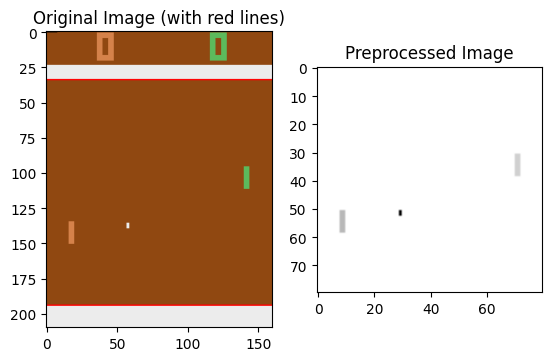

In [5]:
# Test: get 20-th frame
env = gym.make('PongDeterministic-v4')
env.reset()
for _ in range(20):
    action = 1 # fire
    frame, *_ = env.step(action)

processed_frame = preprocess(frame)

display_frame(frame, processed_frame)
env.close()

### 4. Shared Architecture

In this implementation, we define both the Actor and Critic networks, which share a common feature extraction backbone. This design is inspired by the architecture of the [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf), where convolutional layers are used to process raw pixel inputs for reinforcement learning tasks. However, we adapt and modify the network architecture to suit the Actor-Critic framework and the specific requirements of our problem.

#### Action-Value Network in DQN
In DQN, a single network is used to estimate the action-value function $Q(s, a)$, where $s$ represents the state and $a$ represents the action. The network processes raw pixel inputs through convolutional layers, followed by fully connected layers, to output a value for each possible action.

<div style="text-align: center;">
<img src="./images/dqn-network.png" alt="DQN Network Architecture" width="50%">
</div>

#### Shared Feature Extraction Backbone for Actor and Critic
In the Actor-Critic framework, we require two separate outputs:
1. **Actor**: Outputs a probability distribution over actions (policy).
2. **Critic**: Outputs a scalar value representing the estimated value of the current state.

To achieve this, we use a shared feature extraction backbone consisting of convolutional layers and an intermediate fully connected layer. This shared backbone processes the raw pixel inputs (stacked frames) and extracts meaningful features that are used by both the Actor and Critic networks. 

This shared architecture offers several advantages:
- **Reduced Computational Redundancy**: Both networks use the same extracted features, avoiding duplicate computation.
- **Improved Learning Efficiency**: Sharing features ensures that both networks benefit from the same learned representations, leading to better coordination between the Actor and Critic.
- **Simplified Design**: A unified backbone makes the architecture modular and easier to manage.

#### Architecture Overview
The shared feature extraction backbone consists of:
- **Convolutional Layers**: These layers reduce the spatial dimensions of the input while capturing spatial and temporal dependencies in the stacked frames.
- **Intermediate Fully Connected Layer**: This layer transforms the extracted spatial features into a compact representation suitable for the Actor and Critic outputs.

The Actor and Critic networks then use this shared representation to produce their respective outputs:
- **Actor**: A fully connected layer maps the shared representation to action logits, which are converted into probabilities using a softmax or categorical distribution.
- **Critic**: A fully connected layer maps the shared representation to a single scalar value representing the state value $V(s)$.

This modular design ensures that the Actor and Critic networks are tightly coupled and learn from the same extracted features, improving the stability and efficiency of training.



In [16]:
class SharedFeatureExtractor(nn.Module):
    """
    Shared feature extraction network for both Actor and Critic.
    """

    def __init__(self, hidden_dim=128):
        super(SharedFeatureExtractor, self).__init__()
        self.hidden_dim = hidden_dim

        # Convolutional layers
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4, stride=4)  # Input: 80x80x2 -> Output: 20x20x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)  # Input: 20x20x32 -> Output: 9x9x64
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)  # Input: 9x9x64 -> Output: 7x7x64

        # Flattened size after convolutional layers
        self.size = 7 * 7 * 64

        # Fully connected layer for feature extraction
        self.fc = nn.Linear(self.size, hidden_dim)  # Input: 7x7x64 -> Output: 128

    def forward(self, x):
        # Pass through convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Flatten the tensor
        x = x.view(-1, self.size)

        # Pass through the fully connected layer
        x = F.relu(self.fc(x))

        return x

### 5. Define Actor Network

- Actor Network
    - input is the stack of two different frames (which captures the movement)
    - output is number of actions, each neuron represent probability of eachf action, such as,  $P_{\rm right}$, $P_{\rm left}$

<div style="text-align: center;">
        <img src="./images/policy-network.png" alt="Mountain Car Environment" width="60%">
</div>


In [17]:
class Actor(nn.Module):

    def __init__(self, shared_extractor):
        super(Actor, self).__init__()

        self.shared_extractor = shared_extractor
        self.fc_actor = nn.Linear(shared_extractor.hidden_dim, 2)  # Output layer for action probabilities
        
    def forward(self, x):
        # Extract shared features
        features = self.shared_extractor(x)
        
        # Get action logits
        logits = self.fc_actor(features)
        return logits

        
shared_extractor = SharedFeatureExtractor()
actor = Actor(shared_extractor).to(device)
print("Network:\n", actor)

# Test the forward function
print("Testing forward pass...")
dummy_input = torch.randn(1, 2, 80, 80).to(device)
logits = actor(dummy_input)
print(f"Output logits from forward pass: {logits}")


Network:
 Actor(
  (shared_extractor): SharedFeatureExtractor(
    (conv1): Conv2d(2, 32, kernel_size=(4, 4), stride=(4, 4))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (fc): Linear(in_features=3136, out_features=128, bias=True)
  )
  (fc_actor): Linear(in_features=128, out_features=2, bias=True)
)
Testing forward pass...
Output logits from forward pass: tensor([[ 0.0515, -0.0545]], device='mps:0', grad_fn=<LinearBackward0>)


### 6. Define Critic Network

- **Purpose**: The Critic network is used to estimate the value of a given state, which is a scalar representing the expected cumulative reward starting from that state. It helps in guiding the Actor's updates during training by providing a baseline to calculate the advantage function.

- **Input**: The input to the Critic network is a stack of two different frames (just like the Policy network). These frames capture the movement in the environment to provide temporal information.

- **Output**: The output of the Critic network is a single scalar value, $V(s)$, which represents the value of the input state $s$.

<div style="text-align: center;">
<img src="./images/value-network.png" alt="Critic Network Diagram" width="60%">
</div>


In [18]:
class Critic(nn.Module):
    """
    Critic network for value estimation.
    """
    def __init__(self, shared_extractor):
        super(Critic, self).__init__()
        self.shared_extractor = shared_extractor
        self.fc_critic = nn.Linear(shared_extractor.hidden_dim, 1)  # Output layer for state value

    def forward(self, x):
        # Extract shared features
        features = self.shared_extractor(x)
        
        # Get state value
        value = self.fc_critic(features)
        return value


# Instantiate shared feature extractor
shared_extractor = SharedFeatureExtractor()

# Instantiate Critic network
critic = Critic(shared_extractor).to(device)

# Test the Critic network
dummy_input = torch.randn(1, 2, 80, 80).to(device)
value = critic(dummy_input)
print(f"Critic output value: {value}")

Critic output value: tensor([[0.0423]], device='mps:0', grad_fn=<LinearBackward0>)


In [19]:
class ActorCriticNet(nn.Module):
    """
    Actor-Critic network that combines both actor and critic into a single model.
    """
    def __init__(self, hidden_dim=128):
        super(ActorCriticNet, self).__init__()
        # Shared feature extractor
        self.shared_extractor = SharedFeatureExtractor(hidden_dim=hidden_dim)
        # Actor network (output layer for action probabilities)
        self.fc_actor = nn.Linear(hidden_dim, 2)  # Output: logits for action probabilities
        # Critic network (output layer for state value)
        self.fc_critic = nn.Linear(hidden_dim, 1)  # Output: state value

    def forward(self, x):
        # Extract shared features
        features = self.shared_extractor(x)
        # Get action logits from actor
        logits = self.fc_actor(features)
        # Get state value from critic
        value = self.fc_critic(features)
        return logits, value

### 7. Define Agent

In [20]:
class Agent:
    """Interacts with and learns from the environment using A2C algorithm."""
    def __init__(
        self,
        network,
        optimizer=None,
        gamma=0.99,
        entropy_weight=0.01,
        value_loss_weight=1.0,
        n_steps=5,
        seed=42,
        T=None,
        optimizer_lock=None,
    ):
        """
        Initialize an Agent object.

        Params:
            network (ActorCriticNet): ActorCritic network.
            optimizer (torch.optim.Optimizer): Optimizer for training both networks.
            gamma (float): Discount factor.
            n_steps (int): Update network every n steps.
            seed (int): Random seed.
            T (int): Global step counter (for multi-processing, can be ignored here).
            optimizer_lock (Lock): Lock for optimizer updates (not needed here).
        """
        self.network = network
        self.optimizer = optimizer
        self.gamma = gamma
        self.entropy_weight = entropy_weight
        self.value_loss_weight = value_loss_weight
        self.n_steps = n_steps  # Apply gradient updates every n_steps
        self.t_step = 0  # Time step counter

        # Store N-step experiences: (state, action, reward, log_prob, value)
        self.memory = []
        self.device = next(self.network.parameters()).device
    
    def select_action(self, frames, mode='train'):
        """
        Select actions based on policy for either inference or trajectory collection.
        
        Args:
            frames: Tuple of (frame1, frame2) or preprocessed tensor
            mode: Either 'inference' for single action or 'collect' for trajectory collection
            
        Returns:
            For mode='inference': single action value
            For mode='collect': tuple of (states, actions, action_probs)
        """
        # Ensure frames are on the correct device
        states = preprocess_batch(frames) if isinstance(frames, tuple) else frames
        states = states.to(self.device)
        
        # Get action probabilities
        logits, values = self.network(states)
        dist = torch.distributions.Categorical(logits=logits)

        entropies = dist.entropy()
        
        if mode == 'inference':
            # Single instance inference
            action = dist.sample().item()
            return action
         
        # Select actions for Batch trajectory
        actions = dist.sample()
        
        # Calculate action probabilities
        action_probs = dist.log_prob(actions)

        return states, actions, action_probs, entropies, values

    def step(self, states, actions, rewards, log_probs, entropies, values, next_states, dones):
        """Process a step and learn from experience."""
        self.memory.append((states, actions, rewards, log_probs, entropies, values, dones))

        # Increment time step counter
        self.t_step += 1

        if self.t_step % self.n_steps == 0:
            # Compute returns and losses
            with torch.no_grad():
                _, R = self.network(next_states)

            policy_losses = []
            value_losses = []
            entropy_losses = []

            # Compute n-step returns in reverse order
            for i in reversed(range(len(self.memory))):
                states_i, actions_i, rewards_i, log_probs_i, entropies_i, values_i, dones_i = self.memory[i]
                R = rewards_i + self.gamma * (1 - dones_i) * R
                
                advantages = R - values_i
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)

                policy_loss = -(log_probs_i * advantages.detach())

                value_loss = F.smooth_l1_loss(values_i, R)

                # Actor loss for gradient ascent
                policy_losses.append(policy_loss)

                # Entropy loss
                entropy_losses.append(entropies_i)

                # Critic loss for gradient descent
                value_losses.append(value_loss)

            # Reset gradients
            self.optimizer.zero_grad()

            # reduce exploration over time
            self.entropy_weight = max(self.entropy_weight * 0.999, 0.001)

            # Sum up all losses and perform backpropagation
            loss = (
                torch.stack(policy_losses).mean() 
                - self.entropy_weight * torch.stack(entropy_losses).mean() 
                + self.value_loss_weight * torch.stack(value_losses).mean()
            )
            loss.backward()

            # Update network parameters
            self.optimizer.step()

            # Reset memory and time step counter
            self.memory = []
            self.t_step = 0

    def save(self, filename):
        """Save model parameters."""
        torch.save(self.network.state_dict(), filename)

    def load(self, filename):
        """Load model parameters."""
        checkpoint = torch.load(filename)
        self.network.load_state_dict(checkpoint)

In [21]:
# Testing select_action and step with external print statements
env = gym.make('PongDeterministic-v4')

env.reset()
for _ in range(20):
    frame1, *_ = env.step(Action.FIRE.value)
    frame2, *_ = env.step(Action.NOOP.value)

print(f"Shape of frame1: {frame1.shape}")
print(f"Shape of frame2: {frame2.shape}")

# Instantiate shared feature extractor
shared_extractor = SharedFeatureExtractor()

# Instantiate Actor and Critic network
network = ActorCriticNet().to(device)

# Create the optimizer
optimizer = optim.Adam(
    network.parameters(),
    lr=1e-4
)

agent = Agent(network=network, optimizer=optimizer)
agent.network.eval()

# Testing select_action
action = agent.select_action((frame1, frame2), mode="inference")
print(f"Action selected: {action}")

# Testing step with the selected action
frame1, _, done, *_ = env.step(action)
print(f"Env Step on (action: {action}): {frame1.shape}, done: {done}")  # External print to test the step method

env.close()


Shape of frame1: (210, 160, 3)
Shape of frame2: (210, 160, 3)
Action selected: 1
Env Step on (action: 1): (210, 160, 3), done: False


### 5. Game Visualization
Visualize the interaction process of the environment and the policy.

<div style="text-align: center;">
    <img src="./images/interact.png" alt="Mountain Car Environment" width="60%">
</div>

In [22]:
# Random action function using numpy broadcasting
def get_random_action(n):
    return np.random.choice(
        [Action.RIGHTFIRE.value, Action.LEFTFIRE.value],
        size=n
    )

print(f"Sample action on inference: {get_random_action(1).item()}")
print(f"Sample action on collect: {get_random_action(4)}")

Sample action on inference: 4
Sample action on collect: [5 5 5 4]


In [23]:
def perform_random_steps(env, nrand, parallel=False):
    """
    Perform a number of random steps in the environment to initialize the game.
    Supports both single and parallel environments.
    
    Args:
        env: The game environment (single or parallel)
        nrand (int): Number of random steps to perform
        parallel (bool): Whether the environment is parallel
        
    Returns:
        tuple: The last two frames after performing random steps
    """
    # Reset environment
    env.reset()

    # Get environment size (1 for single env, n for parallel envs)
    n = len(env.ps) if parallel else 1
    
    # Unified action definitions
    fire_action = np.full(n, Action.FIRE.value, dtype=np.int32)
    noop_action = np.full(n, Action.NOOP.value, dtype=np.int32)
    
    # Start the game with a FIRE action
    env.step(fire_action.item() if n == 1 else fire_action)
    
    # Initialize frames
    frames1, frames2 = None, None

    # Perform random steps
    for _ in range(nrand):
        # Get and format random action
        action = get_random_action(n)
        frames1, _, dones, *_ = env.step(action.item() if n == 1 else action)
        frames2, _, dones, *_ = env.step(noop_action.item() if n == 1 else noop_action)
        
        # Check termination condition
        if (dones if n == 1 else dones.any()):
            break
    
    return frames1, frames2

In [24]:
def interact(env, agent, max_t=2000, preprocess=None, nrand=5):
    """
    Play a game using the given policy and display the animation.

    Args:
        env: The game environment.
        agent: The agent object with a select_action method.
        max_t (int): Maximum number of timesteps to play.
        preprocess (callable): Function to preprocess frames (optional).
        nrand (int): Number of random steps before using the policy.

    Returns:
        None
    """
    agent.network.eval()
    # Initialize the game and perform random steps
    frame1, frame2 = perform_random_steps(env, nrand)

    selected_frames = []
    for _ in range(max_t):

        with torch.no_grad():
            # Select an action using the policy
            action = agent.select_action((frame1, frame2), mode='inference')

        # Map the action to the environment's action space
        action = Action.LEFTFIRE.value if action == 1 else Action.RIGHTFIRE.value

        # Perform the action and a NOOP step
        frame1, _, done, *_ = env.step(action)
        frame2, _, done, *_ = env.step(Action.NOOP.value)

        # Store the frame (preprocessed or raw)
        selected_frames.append(preprocess(frame1) if preprocess else frame1)

        # End the game if done
        if done:
            break

    env.close()
    save_animation(selected_frames)

Animation saved to animation.mp4


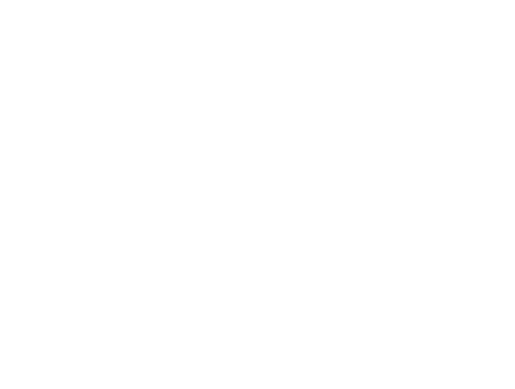

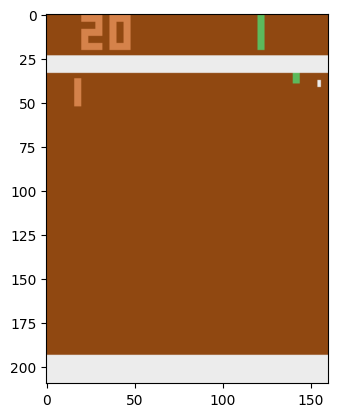

In [15]:
# after interact, open animation.mp4 see whole interact process
env = gym.make('PongDeterministic-v4')

network = ActorCriticNet().to(device)
agent = Agent(network)
interact(env, agent, max_t=2000, nrand=5)

### 8. Define A2C

In [25]:
def a2c(
    envs,
    agent,
    num_episodes=2000,
    max_t=1000,
    window=100,
):
    """
    Training loop for the A2C algorithm.
    """
    n = len(envs.ps)

    # keep track of progress
    scores = []
    best_score = float("-inf")

    for i_episode in range(1, num_episodes + 1):

        # Reset the environment
        frames1, frames2 = perform_random_steps(envs, nrand=5, parallel=True)
        
        total_rewards = np.zeros(n)
        
        agent.t_step = 0
        agent.memory = []

        for t in range(max_t):
            # Select actions based on current policy
            states, actions, log_probs, entropies, values = agent.select_action((frames1, frames2))

            # Map the action to the environment's action space
            actions_np = np.where(actions.cpu().numpy() == 1, Action.LEFTFIRE.value, Action.RIGHTFIRE.value)

            # Observed rewards and next states after execute actions in parallel envs
            frames1, rewards1, dones, *_ = envs.step(actions_np)
            frames2, rewards2, dones, *_ = envs.step([Action.NOOP.value] * n)

            next_states = preprocess_batch((frames1, frames2))

            rewards = rewards1 + rewards2
            total_rewards += rewards

            # Convert rewards and dones to tensors
            dones = torch.tensor(dones, dtype=states.dtype, device=states.device).unsqueeze(1)
            rewards = torch.tensor(rewards, dtype=states.dtype, device=states.device).unsqueeze(1)
            next_states = next_states.to(dtype=states.dtype, device=states.device)

            # Update the Agent
            agent.step(states, actions, rewards, log_probs, entropies, values, next_states, dones)

            if dones.any():
                break
            
        
        # Store mean reward on batch
        avg_score = np.mean(total_rewards)
        scores.append(avg_score)

        if i_episode % window == 0:
            print(f"Episode {i_episode}\tAverage Score: {avg_score:.2f}")
            print(f"Total Rewards on {n} envs: {total_rewards}")

        if avg_score > best_score:
            best_score = avg_score
            agent.save("checkpoint_a2c.pth")
            print(f"Checkpoint saved with new best score: {best_score:.2f}")
    
    envs.close()
    return scores



In [26]:
env_name = 'PongDeterministic-v4'
num_episodes = 600
max_t = 320
n_steps = 3
window = 10

# Create the Actor and Critic networks
network = ActorCriticNet(hidden_dim=128)
network.to(device)

# Create the optimizer
optimizer = optim.Adam(
    network.parameters(),
    lr=1e-4
)

# Initialize the Agent
agent = Agent(
    network=network,
    optimizer=optimizer,
    gamma=0.995,
    n_steps=n_steps,
)

# Parallelized environments to collect multiple examples at once
envs = ParallelEnv('PongDeterministic-v4', n=8, seed=42)

scores = a2c(
    envs=envs,
    agent=agent,
    num_episodes=num_episodes,
    max_t=max_t,
    window=window,
)


A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


Checkpoint saved with new best score: -14.75
Checkpoint saved with new best score: -14.12
Checkpoint saved with new best score: -14.00
Checkpoint saved with new best score: -13.38
Episode 10	Average Score: -13.88
Total Rewards on 8 envs: [-14. -11. -16. -15. -12. -16. -15. -12.]
Episode 20	Average Score: -12.88
Total Rewards on 8 envs: [-14.  -6. -16. -10. -17. -12. -13. -15.]
Checkpoint saved with new best score: -12.88
Checkpoint saved with new best score: -12.25
Episode 30	Average Score: -12.62
Total Rewards on 8 envs: [-15. -13. -17. -16.  -8. -14.  -4. -14.]
Episode 40	Average Score: -13.38
Total Rewards on 8 envs: [ -9. -17. -11. -15. -11. -16. -16. -12.]
Checkpoint saved with new best score: -11.75
Episode 50	Average Score: -14.12
Total Rewards on 8 envs: [-14. -16. -16. -16.  -7. -14. -15. -15.]
Episode 60	Average Score: -12.75
Total Rewards on 8 envs: [-12. -14. -14.  -6. -12. -11. -17. -16.]
Episode 70	Average Score: -13.12
Total Rewards on 8 envs: [-13.  -7. -17. -16. -16. -

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
595   -14.35125
596   -14.34000
597   -14.32625
598   -14.31875
599   -14.32875
Length: 600, dtype: float64

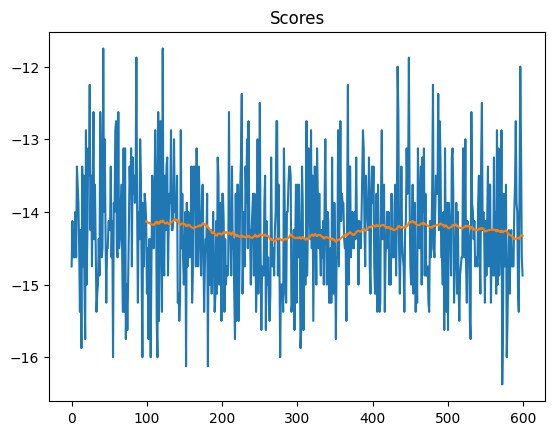

In [27]:
plot_scores(scores)

Animation saved to animation.mp4


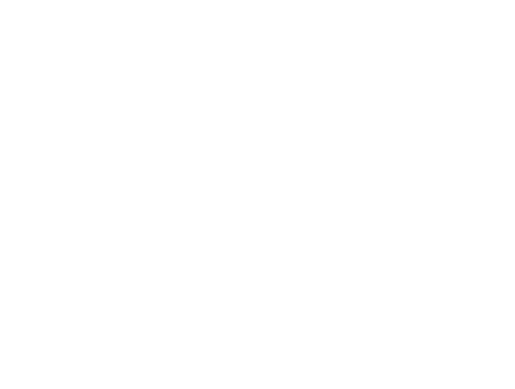

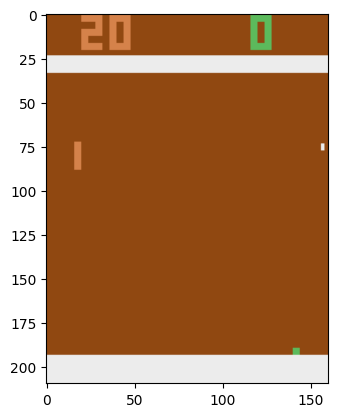

In [28]:
# after interact, open animation.mp4 see whole interact process
env = gym.make('PongDeterministic-v4')

agent.network.eval()
interact(env, agent, max_t=2000, nrand=5)